In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# for data processes
import numpy as np
import csv
import os

# for plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

myseed = 42069
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [2]:
tr_path = '/home/xutian/data/HW01/covid.train.csv'  # path to training data
tt_path = '/home/xutian/data/HW01/covid.test.csv'   # path to testing data


In [3]:
def get_device():
    return 'cuda' if torch.cuda.is_available() else 'cpu'


def plot_learning_curve(loss_record, title=''):
    # loss_record = {'train': [], 'dev': []}  train loss and validation loss
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label = 'train')
    plt.plot(x_2, loss_record['dev'],  c='tab:cyan', label = 'dev')
    
    plt.ylim(0.0, 5.)
    plt.xlabel('Train steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()
    
def plot_pred(dv_set, models, device, lim=35., preds = None, targets = None):
    '''Plot the predictions of the DNN'''
    if preds is None or targets is None:
        preds, targets = [], []
        for x, y in dv_set:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                preds.append(pred.detach().cpu())
                targets.append(y.detach().cpu())
        
        preds = torch.cat(preds, dim = 0).numpy()
        targets = torch.cat(targets, dim = 0).numpy()
        
    figure(figsize=(5, 5))
    plt.scatter(targets, preds, c = 'r', alpha=0.5)
    plt.plot([-0.2, lim], [-0.2, lim], c='b')
    plt.xlim(-0.2, lim)
    plt.ylim(-0.2, lim)
    plt.xlabel('ground truth value')
    plt.ylabel('predicted value')
    plt.title('Ground Truth v.s. Prediction')
    plt.show()

In [4]:
# Covid19 Dataset
class COVID19Dataset(Dataset):
    def __init__(self, path, mode='train', target_only=False):
        self.mode = mode
        # open the csv file
        with open(path, 'r') as fp:
            data = list(csv.reader(fp))
            data = np.array(data[1:])[:, 1:].astype(float)
        
        if not target_only:
            # we have 93 features in the csv table
            feature_indices = list(range(93))
        else:
            pass
        
        if mode == 'test':
            data = data[:, feature_indices]
            self.data = torch.FloatTensor(data)
        else:
            target = data[:, -1]
            data = data[:, feature_indices]
            # train mode
            if mode == 'train':
                indices = [i for i in range(len(data)) if i % 10 != 0]
            elif mode == 'dev':
                indices = [i for i in range(len(data)) if i % 10 == 0]
                
            # convert data into PyTorch tensors
            self.data = torch.FloatTensor(data[indices])
            self.target = torch.FloatTensor(target[indices])
        
        # Normalize features, the first 40 features are on-hot coded state, no need to normalize
        self.data[:, 40:] = \
            (self.data[:, 40:] - self.data[:, 40:].mean(dim = 0, keepdim = True)) \
            / self.data[:, 40:].std(dim = 0, keepdim = True)
        
        self.dim = self.data.shape[1]
        
        print('Finished reading the {} set of COVID 19 Dataset ({} samples found, each dim = {})'
             .format(mode, len(self.data), self.dim))
        
    def __getitem__(self, index):
        if self.mode in ['train', 'dev']:
            return self.data[index], self.target[index]
        else:
            return self.data[index]
        
    def __len__(self):
        return len(self.data)

In [5]:
# data loader
def prep_dataloader(path, mode, batch_size, n_jobs = 0, target_only = False):
    dataset = COVID19Dataset(path, mode=mode, target_only=target_only)
    dataloader = DataLoader(dataset, 
                            batch_size, 
                            shuffle=(mode == 'train'), 
                            drop_last=False, 
                            num_workers=n_jobs, 
                            pin_memory=True)
    return dataloader


tr_set = prep_dataloader(tr_path, 'train', batch_size= 50, target_only=False)
tr_features, tr_target = next(iter(tr_set))
print(tr_target, tr_target.shape)
print(tr_features, tr_features.shape)


Finished reading the train set of COVID 19 Dataset (2430 samples found, each dim = 93)
tensor([ 8.9440, 25.0183, 14.1966, 12.5347, 21.7978, 20.4198,  8.5520, 14.8030,
         5.9249, 28.4408, 11.3705, 23.3380, 24.7259, 26.3706, 12.5000, 10.6081,
        21.8748,  4.9312, 16.8294,  7.7878, 21.5556, 21.3376, 25.0908,  9.0463,
        24.6654,  8.1708, 26.5838, 10.8934, 28.4758,  4.7149, 26.1767, 22.3171,
        12.5824, 28.3824, 23.7719, 25.7534, 25.2843, 23.6692, 32.7656, 14.6036,
        24.4763, 24.8764,  9.9495,  2.7879,  7.9747, 14.1325,  5.0824, 18.9740,
        25.6530, 14.3835]) torch.Size([50])
tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.9956, -1.3421, -0.5218],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.2144,  1.0339,  0.1127],
        [ 0.0000,  0.0000,  0.0000,  ..., -1.0877, -1.0756, -0.5210],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ..., -0.4885,  0.1324, -0.5008],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.2367,  0.4371,  0.4201],
        [ 0.0000,  0.0000,

In [14]:
class NeuralNet(nn.Module):
    '''A simple full connected deep neural network'''
    def __init__(self, input_dim):
        super(NeuralNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    
        self.criterion = nn.MSELoss(reduction='mean')
    
    def forward(self, x):
        return self.net(x).squeeze(1)
    
    def cal_loss(self, pred, target):
        return self.criterion(pred, target)
    


In [15]:
def train(tr_set, dv_set, model, config, device):
    n_epochs = config['n_epochs'] # max number of epochs
    
    #setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas']
    )
    
    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}
    
    early_stop_cnt = 0
    epoch = 0
    
    while epoch < n_epochs:
        model.train()                    # set model to training  mode
        for x, y in tr_set:                         # iterate through the dataloader
            optimizer.zero_grad()                   # set gradient to zero
            x, y = x.to(device), y.to(device)       # move data to device
            pred = model(x)                         # forward pass
            mse_loss = model.cal_loss(pred, y)      # compute loss
            mse_loss.backward()                     # compute gradient(backpropagation)
            optimizer.step()                        # update model with optimizer
            loss_record['train'].append(mse_loss.detach().cpu().item())
            
        # After each epoch, test the model with validation(development) set
        dev_mse = dev(dv_set, model, device)
        if dev_mse < min_mse:
            # Save model if the model is improved
            min_mse = dev_mse     # update min_mse
            print('Saving model (epoch = {:4d}, loss = {:.4f})'.format(epoch + 1, min_mse))
            torch.save(model.state_dict(), config['save_path']) # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
            
        epoch += 1
        loss_record['dev'].append(dev_mse)
        
        if early_stop_cnt > config['early_stop']:
            break
        
    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record
            

In [16]:
def dev(dv_set, model, device):
    model.eval()
    total_loss = 0
    for x, y in dv_set:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():  # disable gradient calculation
            pred = model(x)    # forward pass (compute output)
            mse_loss = model.cal_loss(pred, y) # compute loss
        total_loss += mse_loss.detach().cpu().item() * len(x) # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)  # compute averate loss
    
    return total_loss

In [17]:
def test(tt_set, model, device):
    model.eval()  # set model to evalutation mode
    preds = []
    for x in tt_set:  # iterate through the dataloader
        x = x.to(device)
        with torch.no_grad(): # disable gradient calculation
            pred = model(x)   # forward pass
            preds.append(pred.detach().cpu()) # collect prediction
    preds = torch.cat(preds, dim = 0).numpy() # concanate all predictions and convert to a numpy array
    return preds

In [18]:
device = get_device()
os.makedirs('models', exist_ok=True)  # the training model will be saved to ./models
target_only = False

config = {
    'n_epochs': 3000,                # maximum number of epochs
    'batch_size': 270,               # mini-batch size for dataloader
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.001,                 # learning rate of SGD
        'momentum': 0.9              # momentum for SGD
    },
    'early_stop': 200,               # early stopping epochs (the number epochs since your model's last improvement)
    'save_path': 'models/model.pth'  # your model will be saved here
}

In [19]:
# load data and model
tr_set = prep_dataloader(tr_path, 'train', config['batch_size'], target_only=target_only)
dv_set = prep_dataloader(tr_path, 'dev', config['batch_size'], target_only=target_only)
tt_set = prep_dataloader(tt_path, 'test', config['batch_size'], target_only=target_only)

Finished reading the train set of COVID 19 Dataset (2430 samples found, each dim = 93)
Finished reading the dev set of COVID 19 Dataset (270 samples found, each dim = 93)
Finished reading the test set of COVID 19 Dataset (893 samples found, each dim = 93)


In [20]:
model = NeuralNet(tr_set.dataset.dim).to(device)

In [21]:
model_loss, model_loss_record = train(tr_set, dv_set, model, config, device)

Saving model (epoch =    1, loss = 49.7756)
Saving model (epoch =    2, loss = 37.5044)
Saving model (epoch =    3, loss = 24.2799)
Saving model (epoch =    4, loss = 12.0118)
Saving model (epoch =    5, loss = 7.5592)
Saving model (epoch =    6, loss = 6.2870)
Saving model (epoch =    7, loss = 5.2704)
Saving model (epoch =    8, loss = 4.3176)
Saving model (epoch =    9, loss = 3.8437)
Saving model (epoch =   10, loss = 3.4650)
Saving model (epoch =   11, loss = 3.1548)
Saving model (epoch =   12, loss = 2.8655)
Saving model (epoch =   13, loss = 2.7081)
Saving model (epoch =   14, loss = 2.4864)
Saving model (epoch =   15, loss = 2.3446)
Saving model (epoch =   16, loss = 2.2370)
Saving model (epoch =   17, loss = 2.1144)
Saving model (epoch =   18, loss = 2.0114)
Saving model (epoch =   19, loss = 1.9672)
Saving model (epoch =   20, loss = 1.8401)
Saving model (epoch =   22, loss = 1.7110)
Saving model (epoch =   23, loss = 1.6998)
Saving model (epoch =   24, loss = 1.6084)
Saving 

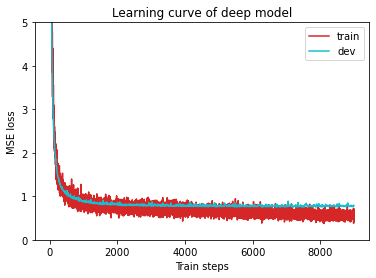

In [22]:
plot_learning_curve(model_loss_record, title='deep model')

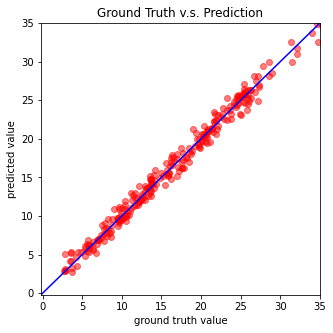

In [23]:
del model

model = NeuralNet(tr_set.dataset.dim).to(device)
checkpoint = torch.load(config['save_path'], map_location='cpu') # load the best mode
model.load_state_dict(checkpoint)
plot_pred(dv_set, model, device)

### Testing
The prediction of your model on testing set will be stored at `pred.csv`

In [24]:
# save prediction
def save_pred(preds, file):
    print('Saving results to {}'.format(file))
    
    with open(file, 'w') as fp:
        writer = csv.writer(fp)
        writer.writerow(['id', 'tested_positive'])
        for i, p in enumerate(preds):
            writer.writerow([i, p])
            
preds = test(tt_set, model, device)
save_pred(preds, 'pred.csv')

Saving results to pred.csv



## **Medium Baseline**
* Feature selection: 40 states + 2 `tested_positive` (`TODO` in dataset)

## **Strong Baseline**
* Feature selection (what other features are useful?)
* DNN architecture (layers? dimension? activation function?)
* Training (mini-batch? optimizer? learning rate?)
* L2 regularization
* There are some mistakes in the sample code, can you find them?